# Introduction

A package for large-scale, time-domain forward-modeling of astronomical light curve data. Simulations incorporate realistic effects, including survey cadence, dust extinction, and instrument noise models. TDAstro is designed to enable user extensibility, such as adding new source models, effects, and instruments, while ensuring scalability.

In this tutorial, we discuss the overall flow of TDAstro and how to use it to run simulations. The goal is to get a new user started and allow them to explore the package.

Later tutorials cover topics in more depth, including:
  - Sampling Parameters (sampling.ipynb)
  - Adding new source types (adding_sources.ipynb)
  - Add new effect types (addings_effects.ipynb)
  - Working directly with passbands (passband-demo.ipynb)
  - Working directly with OpSims (opsim_notebook.ipynb)

## Program Flow

TDAstro generates synthetic light curves using the flow shown in the illustration below. A `PhysicalModel` (the model of a source) and information about the parameter distributions is used to sample fake sources. These are combined with information from an `OpSim` (or other survey information) to generate sample flux densities at a given set of times and wavelengths (or passbands), accounting for effects such as redshift. The simulator also applies other relevant effects to the rest frame flux densities (e.g. dust extinction) and the observer frame flux densities (detector noise). At the end the code outputs a series of samples.

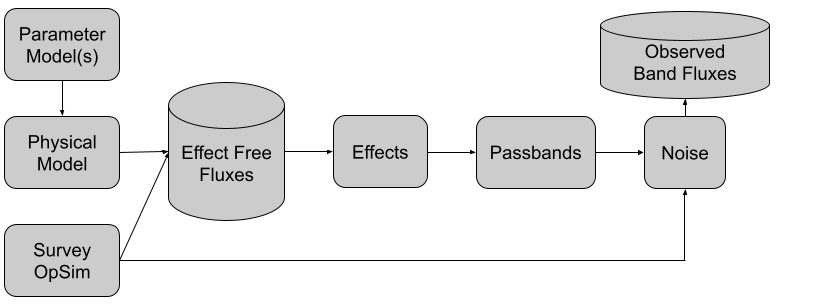

In [17]:
from IPython.display import Image

Image("../_static/tdastro-intro.png")

## Sources

All light curves are generated from source objects that are a subclass of the `PhysicalObject` class. These source objects provide mechanisms for:
  - Sampling their parameters from given distributions,
  - Generating flux densities at given times and wavelengths (or passbands), and
  - Applying noise and other effects to the observations.

A major goal of TDAstro is to be easily extensible so that users can create and analyze their own source models. See the `adding_sources.ipynb` notebook for examples of how to add a new type of source.

Each "sample" of the data consists of a new sampling of the source's parameters and a generation of flux densities from those parameters. Thus, when a user generates a hundred samples, they are generating 100 light curves from 100 sample sources.

We can demonstrate this using a toy model that generates fluxes using a sin wave. Three of the models parameters (`brightness`, `frequency`, and `t0`) are chosen from uniform distributions and two (`RA` and `dec`) are chosen from a Gaussian that matches the toy survey information we will load later in this notebook. 

TDAstro provides tools for generating parameters from a range of sources and distributions. For example we can sample (RA, dec) directly from the survey data itself. For more information on how to how to define the parameter settings, see the `sampling.ipynb` notebook.

In [2]:
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.sources.basic_sources import SinWaveSource

source_model = SinWaveSource(
    ra=NumpyRandomFunc("normal", loc=200.5, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=-50.0, scale=0.01),
    brightness=NumpyRandomFunc("uniform", low=100.0, high=200.0),
    frequency=NumpyRandomFunc("uniform", low=1.0, high=5.0),
    t0=NumpyRandomFunc("uniform", low=0.0, high=10.0),
)

We can manually evalute a source model using the `evaluate()` function where we provide the wavelengths and times to sample:

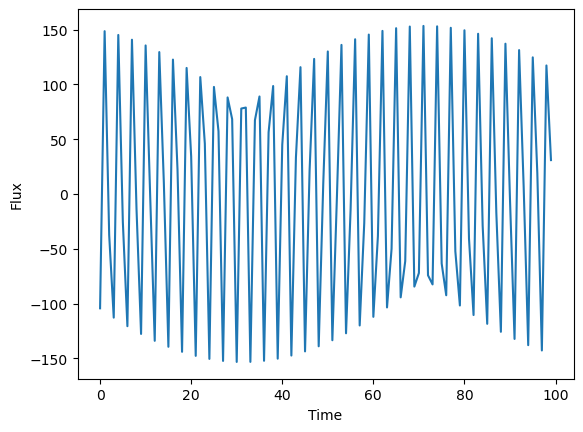

In [3]:
import numpy as np
import matplotlib.pyplot as plt

times = np.arange(100.0)
wavelengths = np.array([7000.0])
fluxes = source_model.evaluate(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

In [9]:
fluxes[0,:]

array([[-150.18808572],
       [ 132.69629754],
       [ -66.71788707],
       [ -23.63893523],
       [ 105.35819835],
       [-148.58005601],
       [ 137.51143845],
       [ -76.19676806],
       [ -12.95985407],
       [  97.3810046 ],
       [-146.21957991],
       [ 141.6301872 ],
       [ -85.28976964],
       [  -2.21514099],
       [  88.9106492 ],
       [-143.11861145],
       [ 145.03168542],
       [ -93.95084259],
       [   8.54079012],
       [  79.99002813],
       [-139.29285471],
       [ 147.69870707],
       [-102.13612509],
       [  19.25346854],
       [  70.66431765],
       [-134.76168427],
       [ 149.6177457 ],
       [-109.80416482],
       [  29.86864261],
       [  60.98074547],
       [-129.54804711],
       [ 150.77908282],
       [-116.91612892],
       [  40.33255443],
       [  50.98835162],
       [-123.67834639],
       [ 151.17683712],
       [-123.43600064],
       [  50.59221215],
       [  40.73774006],
       [-117.18230773],
       [ 150.808

The power of the simulation software is that we can generate a large number of light curves from a distribution of sources. We start by using a `PhysicalModel` object's `sample_parameters` function to sample the parameters can create this distribution of source object. 

Let's start with generating 5 source objects. We save the samples in a `GraphState` object. Users will not need to deal with this object directly, but it can be used to peak at the underlying parameters.

In [5]:
state = source_model.sample_parameters(num_samples=3)
print(state)

NumpyRandomFunc:normal_1:
    loc: [200.5 200.5 200.5]
    scale: [0.01 0.01 0.01]
    function_node_result: [200.49412441 200.49384    200.50962318]
SinWaveSource_0:
    ra: [200.49412441 200.49384    200.50962318]
    dec: [-49.98888492 -49.99496169 -50.0012093 ]
    redshift: [None None None]
    t0: [0.87842556 9.74352581 6.79262807]
    distance: [None None None]
    brightness: [151.17698339 125.84407549 174.11318539]
    frequency: [1.40226568 1.79681838 1.3991457 ]
NumpyRandomFunc:normal_2:
    loc: [-50. -50. -50.]
    scale: [0.01 0.01 0.01]
    function_node_result: [-49.98888492 -49.99496169 -50.0012093 ]
NumpyRandomFunc:uniform_3:
    low: [0. 0. 0.]
    high: [10. 10. 10.]
    function_node_result: [0.87842556 9.74352581 6.79262807]
NumpyRandomFunc:uniform_4:
    low: [100. 100. 100.]
    high: [200. 200. 200.]
    function_node_result: [151.17698339 125.84407549 174.11318539]
NumpyRandomFunc:uniform_5:
    low: [1. 1. 1.]
    high: [5. 5. 5.]
    function_node_result: [1

Most users will not need to interact directly with the `GraphState` object, but at a very high level it can be viewed as a nested dictionary where parameters are indexed by two levels. First, the node name or identifier tells the code which part of the simulation the parameter belongs to. This level of identification is necessary to allow different stages to use parameters with the same name. Second, the parameter name defines the actual parameter name.

Each parameter name corresponds to a list of samples. These sampled together so that the i-th entires of each parameter represent a single, mutually consistent sampling of parameter space. For a lot more detail see the `GraphState` section in the `sampling.ipynb` notebook. For now it is sufficient to know that `state` is tracking the sampled parameters.

By passing the sampled state into `evaluate()` we can generate multiple light curves (one for each source) at once:

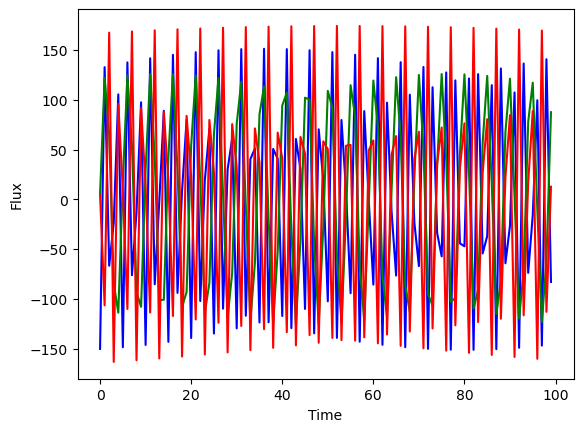

In [6]:
fluxes = source_model.evaluate(times, wavelengths, state)

plt.plot(times, fluxes[0, :], color="blue")
plt.plot(times, fluxes[1, :], color="green")
plt.plot(times, fluxes[2, :], color="red")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Effects

Users can add effects to `PhysicalModel` objects to account for real world aspects such as noise and dust extinction. For more detail on effects, including how to define your own, see the `adding_effects.ipynb` notebook.

Note: Detector noise is not an added effect, but rather automatically included with the `OpSim` information (see the `OpSim` section below for more details).

For this demo, we add a simple white noise effect to the source. For real simulations we would want to add a range of effects, such as dust extinction.

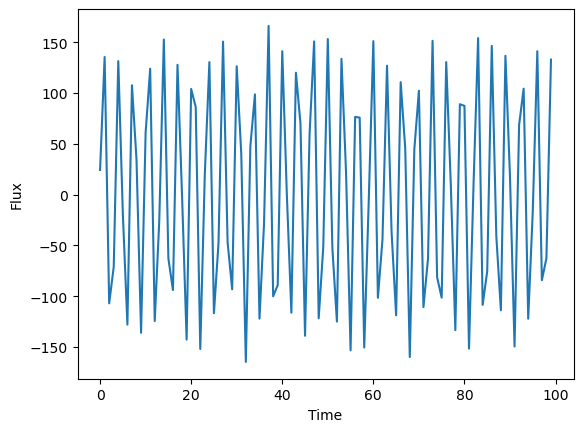

In [10]:
from tdastro.effects.white_noise import WhiteNoise

# Create the white noise effect.
white_noise = WhiteNoise(white_noise_sigma=10.0)
source_model.add_effect(white_noise)

# Evaluate the model with white noise applied (a single sample).
flux = source_model.evaluate(times, wavelengths)
plt.plot(times, flux)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## OpSim and Passbands

To generate a reasonable simulation we need to provide instrument and survey information. We use two classes `OpSim` and `PassbandGroup` to load and work with this information.

### OpSim

The `OpSim` object is used to store survey information, including pointings and weather conditions. It is named after Rubin’s simulated operations database (OpSim), but will be extended to support real survey information from a range of surveys. For more detail on the `OpSim` class, its capabilities, and how to work with it, see the `opsim_notebook.ipynb` notebook.

The `OpSim` class is also used to extract information about the detector for modeling detector noise.

For this demo we load a small example database included with the code.

In [11]:
from tdastro.opsim.opsim import OpSim

opsim_file = "../../tests/tdastro/data/opsim_shorten.db"
ops_data = OpSim.from_db(opsim_file)

print(f"Loaded an opsim database with {len(ops_data)} entries.")
print(f"Columns: {ops_data.columns}")

Loaded an opsim database with 100 entries.
Columns: Index(['observationId', 'fieldRA', 'fieldDec', 'observationStartMJD',
       'flush_by_mjd', 'visitExposureTime', 'filter', 'rotSkyPos',
       'rotSkyPos_desired', 'numExposures', 'airmass', 'seeingFwhm500',
       'seeingFwhmEff', 'seeingFwhmGeom', 'skyBrightness', 'night', 'slewTime',
       'visitTime', 'slewDistance', 'fiveSigmaDepth', 'altitude', 'azimuth',
       'paraAngle', 'psudoParaAngle', 'cloud', 'moonAlt', 'sunAlt', 'note',
       'scheduler_note', 'target_name', 'block_id', 'observationStartLST',
       'rotTelPos', 'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec',
       'moonRA', 'moonDec', 'moonDistance', 'solarElong', 'moonPhase',
       'cummTelAz', 'scripted_id', 'zp_nJy'],
      dtype='object')


### PassbandGroup

The `PassbandGroup` object provides a mechanism for loading and applying the instrument’s passband information. Users can manually specify the passband values, load from given files, or load from a preset (which will download the files if needed). For more detail on the `PassbandGroup` class, see the `passband-demo.ipynb` notebook.

For this demo, we load in the preset LSST filters.

In [12]:
from tdastro.astro_utils.passbands import PassbandGroup

# Use a (possibly older) cached version of the passbands to avoid downloading them.
table_dir = "../../tests/tdastro/data/passbands"
passband_group = PassbandGroup(preset="LSST", table_dir=table_dir)
print(passband_group)

2025-06-03 12:56:55,259 - INFO - Loading passbands from preset LSST
2025-06-03 12:56:55,260 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/u.dat
2025-06-03 12:56:55,274 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/g.dat
2025-06-03 12:56:55,282 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/r.dat
2025-06-03 12:56:55,286 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/i.dat
2025-06-03 12:56:55,291 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/z.dat
2025-06-03 12:56:55,296 - INFO - Loading passband from file: ../../tests/tdastro/data/passbands/LSST/y.dat


PassbandGroup containing 6 passbands: LSST_u, LSST_g, LSST_r, LSST_i, LSST_z, LSST_y


## Generate the simulations

The simulation itself is run using a call to the `simulate_lightcurves()` function. This function will perform the parameter sampling, query the source, and apply any effects. It applies both source effects (as described in the “Effects” section) and detector noise (as described in the “OpSim” section). 

The data from `simulate_lightcurves()` is returned as a [nested-pandas dataframe](https://github.com/lincc-frameworks/nested-pandas) for easy analysis. Each row corresponds to a single source. The nested columns include the time series information for the light curves.

In [13]:
from tdastro.simulate import simulate_lightcurves

lightcurves = simulate_lightcurves(
    source_model,  # The source to simulate (including effects).
    1_000,  # The number of lightcurves to simulate.
    ops_data,  # The survey information.
    passband_group,  # The passband information.
)
print(lightcurves)

      id          ra        dec  nobs     z  \
0      0  200.508230 -50.002923     2  None   
1      1  200.511318 -49.988213     2  None   
..   ...         ...        ...   ...   ...   
998  998  200.489691 -50.010971     2  None   
999  999  200.488163 -50.003919     2  None   

                                                params  \
0    {'NumpyRandomFunc:normal_1.loc': 200.5, 'Numpy...   
1    {'NumpyRandomFunc:normal_1.loc': 200.5, 'Numpy...   
..                                                 ...   
998  {'NumpyRandomFunc:normal_1.loc': 200.5, 'Numpy...   
999  {'NumpyRandomFunc:normal_1.loc': 200.5, 'Numpy...   

                                            lightcurve  
0    [{mjd: 60796.001439, filter: 'r', flux: -97.05...  
1    [{mjd: 60796.001439, filter: 'r', flux: -339.5...  
..                                                 ...  
998  [{mjd: 60796.001439, filter: 'r', flux: -96.54...  
999  [{mjd: 60796.001439, filter: 'r', flux: -16.18...  

[1000 rows x 7 columns]


We can drill down into a single row of the results (e.g. source number 0)

In [14]:
print(lightcurves.iloc[0])

id                                                            0
ra                                                    200.50823
dec                                                  -50.002923
nobs                                                          2
z                                                          None
params        {'NumpyRandomFunc:normal_1.loc': 200.5, 'Numpy...
lightcurve                mjd filter        flux     fluxerr...
Name: 0, dtype: object


and view the light curve for that source

In [15]:
print(lightcurves.iloc[0].lightcurve)

            mjd filter        flux     fluxerr  flux_perfect
0  60796.001439      r  -97.055214  176.487906     10.378428
1  60796.025350      g -139.184395  102.812447    -62.747242


As shown each row in the `lightcurves` table includes all the information for that source and an embedded table containing the source's lightcurve according to the survey strategy.

Finally we can extract the parameters used to generate the source (the `GraphState`) from the "params" column:

In [16]:
print(lightcurves.iloc[0].params)

{'NumpyRandomFunc:normal_1.loc': 200.5, 'NumpyRandomFunc:normal_1.scale': 0.01, 'NumpyRandomFunc:normal_1.function_node_result': 200.5082299409488, 'SinWaveSource_0.ra': 200.5082299409488, 'SinWaveSource_0.dec': -50.002922856011516, 'SinWaveSource_0.redshift': None, 'SinWaveSource_0.t0': 1.6773326329047589, 'SinWaveSource_0.distance': None, 'SinWaveSource_0.brightness': 187.1882396695848, 'SinWaveSource_0.frequency': 2.7227622512422562, 'SinWaveSource_0.white_noise_sigma': 10.0, 'NumpyRandomFunc:normal_2.loc': -50.0, 'NumpyRandomFunc:normal_2.scale': 0.01, 'NumpyRandomFunc:normal_2.function_node_result': -50.002922856011516, 'NumpyRandomFunc:uniform_3.low': 0.0, 'NumpyRandomFunc:uniform_3.high': 10.0, 'NumpyRandomFunc:uniform_3.function_node_result': 1.6773326329047589, 'NumpyRandomFunc:uniform_4.low': 100.0, 'NumpyRandomFunc:uniform_4.high': 200.0, 'NumpyRandomFunc:uniform_4.function_node_result': 187.1882396695848, 'NumpyRandomFunc:uniform_5.low': 1.0, 'NumpyRandomFunc:uniform_5.high

## Conclusion

This tutorial barely scratches the surface on what TDAstro can do and how it operates. The goal is to provide an overview. Interested users are encouraged to explore the other tutorial notebooks or reach out directly to the team.